# Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 2528 files belonging to 2 classes.


In [4]:
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

In [6]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [7]:
# Labels of the batch's images
# 1 = oranges, 0 = apples
batch[1]

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0])

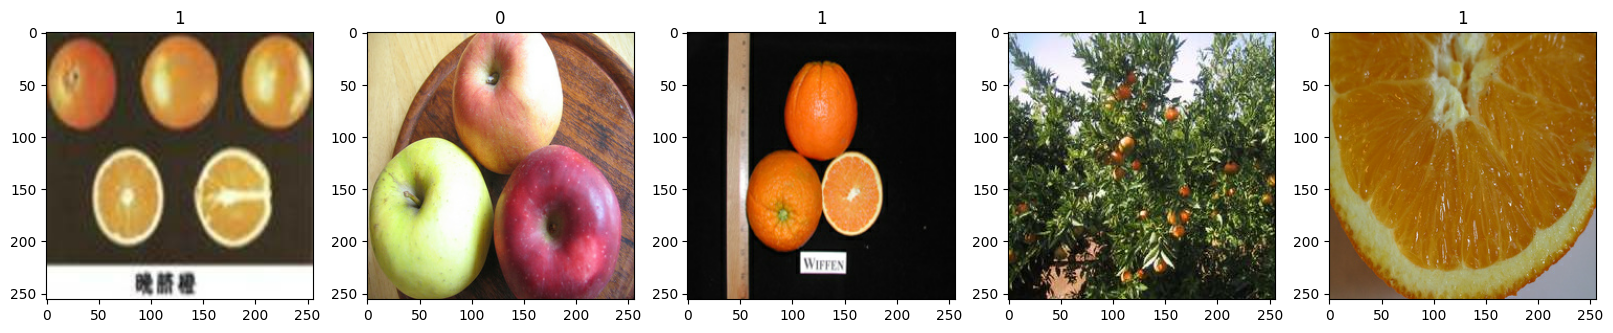

In [8]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [9]:
data = data.map(lambda x,y: (x/255, y))

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
# Number of batches per test design dataset
print(train_size, val_size, test_size)

55 15 7


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Modelling

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
55/55 [==============================] - 51s 921ms/step - loss: 0.4311 - accuracy: 0.8170 - val_loss: 0.2506 - val_accuracy: 0.9083
Epoch 2/20
55/55 [==============================] - 50s 909ms/step - loss: 0.2539 - accuracy: 0.9011 - val_loss: 0.1899 - val_accuracy: 0.9250
Epoch 3/20
55/55 [==============================] - 49s 880ms/step - loss: 0.2150 - accuracy: 0.9284 - val_loss: 0.2226 - val_accuracy: 0.9000
Epoch 4/20
55/55 [==============================] - 57s 1s/step - loss: 0.1684 - accuracy: 0.9409 - val_loss: 0.1815 - val_accuracy: 0.9312
Epoch 5/20
55/55 [==============================] - 61s 1s/step - loss: 0.1660 - accuracy: 0.9415 - val_loss: 0.1204 - val_accuracy: 0.9375
Epoch 6/20
55/55 [==============================] - 66s 1s/step - loss: 0.1181 - accuracy: 0.9591 - val_loss: 0.1448 - val_accuracy: 0.9500
Epoch 7/20
55/55 [==============================] - 66s 1s/step - loss: 0.0987 - accuracy: 0.9665 - val_loss: 0.1076 - val_accuracy: 0.9542
Epoch 8/20


# Evaluation

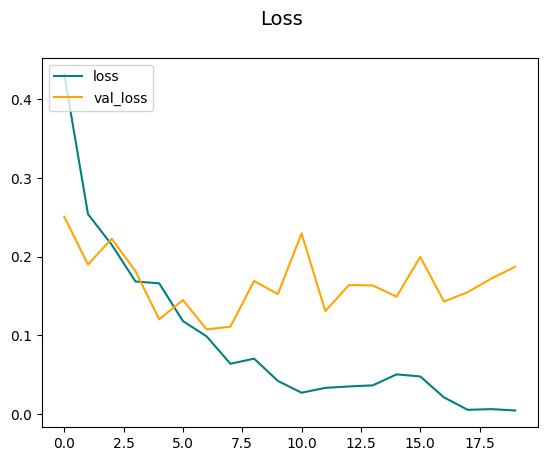

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=14)
plt.legend(loc="upper left")
plt.show()

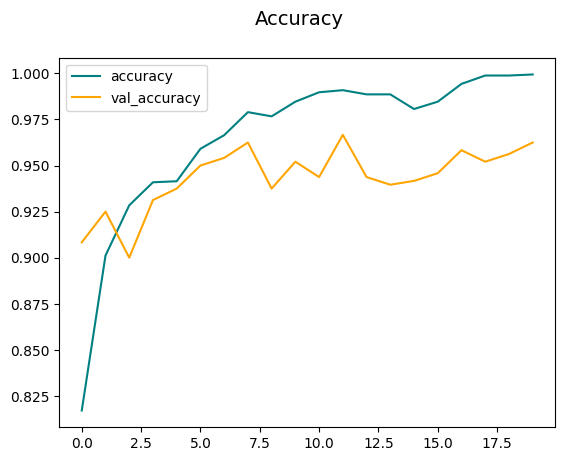

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=14)
plt.legend(loc="upper left")
plt.show()

In [22]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 225ms/step


In [24]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.952, shape=(), dtype=float32) tf.Tensor(0.93700784, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


# Testing

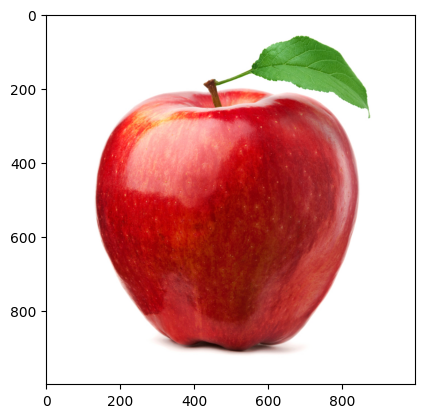

In [25]:
img = cv2.imread("apple_158989157.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5: 
    print(f'Predicted class is Orange')
else:
    print(f'Predicted class is Apple')

In [27]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 163ms/step


In [28]:
yhat

array([[2.1996529e-07]], dtype=float32)

In [29]:
if yhat > 0.5: 
    print(f'Predicted class is Orange')
else:
    print(f'Predicted class is Apple')

Predicted class is Apple


In [30]:
model.save(os.path.join('models','apples2oranges.h1'))

INFO:tensorflow:Assets written to: models\apples2oranges.h1\assets


INFO:tensorflow:Assets written to: models\apples2oranges.h1\assets


In [31]:
new_model = load_model('models/apples2oranges.h1')

In [32]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 111ms/step


array([[2.1996529e-07]], dtype=float32)